In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import numpy as np

In [2]:
db = pd.read_csv('../data/dbNSFP3.2.clinvar_clean.txt',
                  sep='\t')

/Users/d/work/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,8,9,10,11,67,68,69,70,71,72,73,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
db['aa_change'] = db['aaref'] + '=>' + db['aaalt']

## Create simple table for just proteins with glycosylation sites with distance annotation

In [4]:
p_d = pd.read_csv('../data/protein_aa_distance.txt',
                       sep='\t',
                       header=None,index_col=0)

In [5]:
p_d.columns = ['protein','aa','distance_to_feature']

In [6]:
db = db[['aapos','Uniprot_acc_Polyphen2','clinvar_pathogenic','aa_change']]
db = db[db['Uniprot_acc_Polyphen2'] != '.']
db.head()

,aapos,Uniprot_acc_Polyphen2,clinvar_pathogenic,aa_change
3,215;353,O00468,likely benign,Q=>R
4,590;728,O00468,benign,E=>V
5,950;1088,O00468,likely benign,L=>F
6,997;1135,O00468,likely benign,Q=>R
7,1151;1289,O00468,likely benign,P=>L


## Going through the clinvar database and matching amino acids
If there are multiple amino acids per variant, I am just using the first one as it is ordered by canonical transcripts.

In [39]:
protein_list

['Q4R9M9', 'Q4R9M7', 'Q4VXC4', 'Q4R9M8', 'O60333', 'O60333-2', 'O60333-3']

In [40]:
aa_list

['98']

['likely benign',
 'likely benign',
 'benign',
 'benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'likely benign',
 'likely benign',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'benign',
 'likely pathogenic',
 'pathogenic',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'likely benign',
 'pathogenic',
 'pathogenic',
 'p

In [35]:
aas = []
proteins = []
clinvars = []
aa_changes = []
i_s = []
for i in db.index:
    one_var = db.loc[i]
    aa_list = one_var['aapos'].split(';')
    protein_list = one_var['Uniprot_acc_Polyphen2'].split(';')
    path = one_var['clinvar_pathogenic']
    aa_change = one_var['aa_change']
    if len(protein_list) > 6:
        break
    for p in protein_list:
        for aa in aa_list:
            aas.append(aa)
            proteins.append(p)
            clinvars.append(path)
            aa_changes.append(aa_change)
            i_s.append(i)

In [14]:
flat_db = pd.DataFrame([pd.Series(aas,dtype=int),
                  pd.Series(proteins),
                  pd.Series(clinvars),
                  pd.Series(aa_changes),
                  pd.Series(i_s)])
flat_db = flat_db.transpose()
flat_db.columns = ['aa','protein','clinvar_path','aa_change','clinvar_index']

/Users/d/work/conda/lib/python3.7/site-packages/numpy/core/numeric.py:2339: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [15]:
print(flat_db.shape)
print('Dropping duplicates')
flat_db =  flat_db.drop_duplicates(subset=['aa','protein'])
print(flat_db.shape)

(295521, 5)
Dropping duplicates
(156796, 5)


In [16]:
p_d.head()

,protein,aa,distance_to_feature
0,,,
402407,P05107,28,0.0
820774,O14656,143,0.0
1068490,Q92820,139,0.0
196505,Q9NY72,97,0.0
1159219,O15118,916,0.0


In [17]:
flat_db.head()

,aa,protein,clinvar_path,aa_change,clinvar_index
0,215,O00468,likely benign,Q=>R,3
1,353,O00468,likely benign,Q=>R,3
2,590,O00468,benign,E=>V,4
3,728,O00468,benign,E=>V,4
4,950,O00468,likely benign,L=>F,5


In [52]:
merged = flat_db.merge(p_d,on=['aa','protein'],how='outer')

In [53]:
print(merged.shape)
print('dropping no clinvar proteins')
merged = merged.dropna(subset=['clinvar_path'])
print(merged.shape)

(543599, 6)
dropping no clinvar proteins
(156796, 6)


# Dropping any clinvar variants that are not in glycosylated proteins

In [54]:
g_proteins = list(p_d['protein'].unique())

In [55]:
merged = merged[merged['protein'].isin(g_proteins)]
print(merged.shape)

(5037, 6)


# Any variants that do not have feature distances are given a psuedo distance

Text(160,1600,'150 will be psuedo distance for variants w/o distances')

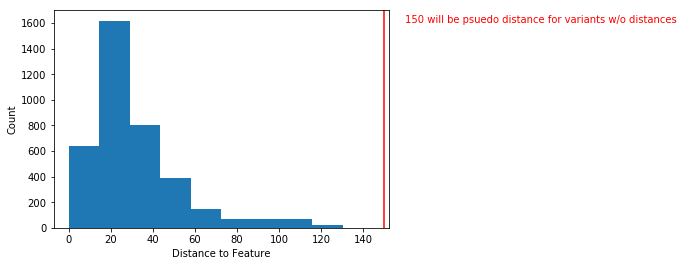

In [66]:
plt.hist(merged['distance_to_feature'].dropna())
plt.xlabel('Distance to Feature')
plt.ylabel('Count')
plt.axvline(x=150,color='r')
plt.text(160,1600,'150 will be psuedo distance for variants w/o distances',color='r')

In [42]:
high_distance = 150

In [43]:
merged['distance_to_feature'] = merged['distance_to_feature'].fillna(high_distance)

## Filtering sites where distance to feature == 0, which is presumably the glycosylation site

In [44]:
merged = merged[merged['distance_to_feature'] > 0]
merged.shape

(5018, 6)

## Dropping duplicates for clinvar variants with multiple AA, keeping closest to glycosite

In [48]:
merged = merged.sort_values(by='distance_to_feature',ascending=True).drop_duplicates(subset='clinvar_index',keep='first')

In [49]:
merged.shape

(3010, 6)

## Dropping duplicated variants really reduces our total # of variants... maybe need to go back to the swiss databank?

In [50]:
merged.to_csv('../data/clinvar_glycoproteins_distances.txt',sep='\t')